In [1]:
import numpy as np
import matplotlib.pyplot as plt

First, we'll simulate stock price using the given parameters.

In [2]:
def gen_stock_price(S_0, r, sigma, T, n = 1000):
  dt = T / n
  t = np.linspace(0, T, n+1, endpoint=True)
  S = np.zeros(n+1); S[0] = S_0 # initializing the stock price
  for i in range(n):
    dS = (r * dt + sigma * np.random.normal(loc=0, scale=np.sqrt(dt))) * S[i] # GBM stock price simulation
    S[i+1] = S[i] + dS
  return (t, S)
# n= 1000 steps 
# r= risk free interest rate
# dt= time steps: entire time period / total number of steps= 'T'/'n'
# linspace divided a starting point and ending point into equally spaced intervals
# np.random.normal(0, np.sqrt(dt)) generates the brownian motion, characteristic normal distribution with mean 0 and variance dt (standard deviation= sqrt(dt)) 

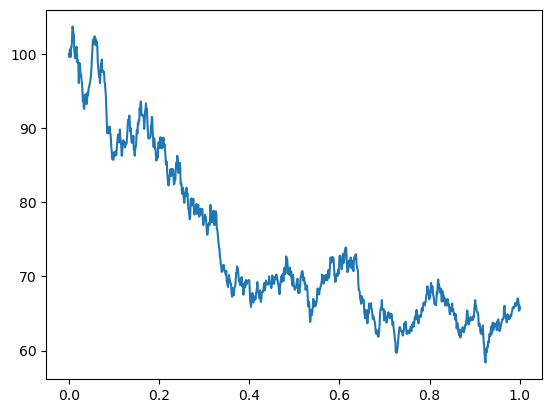

In [6]:
t, S = gen_stock_price(100, 0.06, 0.30, 1)
plt.plot(t, S)
# each time we run this code we generate a new stock price path
# then for each of these stock price paths, we calculate the option pay-offs at the end

European Call

In [7]:
def eur_call(S_0, K, r, sigma, T):
  nSim = 10000 # 10000 monte carlo simulations 
  C = np.zeros(nSim) #array that holds all our values, 10000 element array
  for i in range(nSim):
    _, S = gen_stock_price(S_0, r, sigma, T)
    C_T = np.max([S[-1] - K, 0]) # option payoffs
    C[i] = np.exp(-r * T) * C_T # present value of payoffs
  return C

In [8]:
C = eur_call(100, 120, 0.06, 0.30, 1)

In [31]:
C.mean() # estimated call option price
# the higher the simulations, the more the option value from the monte carlo simulation converges to the black-scholes formula

7.10235719590856

In [32]:
C.std()

16.634248345857728

(array([1.40198538e-01, 1.20288686e-02, 1.26510515e-02, 1.08104272e-02,
        9.87715290e-03, 9.66975861e-03, 8.94387861e-03, 7.18102717e-03,
        6.01443431e-03, 5.96258574e-03, 4.82191716e-03, 4.69229573e-03,
        3.88864287e-03, 3.78494573e-03, 2.61835287e-03, 2.35911001e-03,
        2.02209429e-03, 1.76285144e-03, 1.58138144e-03, 1.29621429e-03,
        8.55501432e-04, 1.11474429e-03, 8.81425718e-04, 6.22182860e-04,
        5.96258574e-04, 3.88864287e-04, 4.66637145e-04, 2.59242858e-04,
        3.11091430e-04, 4.14788573e-04, 2.59242858e-04, 1.03697143e-04,
        7.77728575e-05, 1.29621429e-04, 5.18485716e-05, 5.18485716e-05,
        1.29621429e-04, 2.59242858e-05, 1.03697143e-04, 7.77728575e-05,
        2.59242858e-05, 2.59242858e-05, 0.00000000e+00, 0.00000000e+00,
        5.18485716e-05, 0.00000000e+00, 0.00000000e+00, 2.59242858e-05,
        0.00000000e+00, 2.59242858e-05]),
 array([  0.        ,   3.85738688,   7.71477376,  11.57216064,
         15.42954752,  19.2869

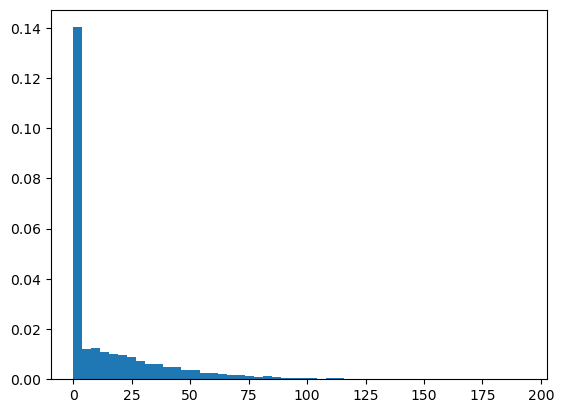

In [14]:
plt.hist(C, bins=50, density=True)

**Antithetic Variance Reduction Technique**
###### Reduces variation in simulations from one run to the other.

In [15]:
def gen_stock_price_antithetic(S_0, r, sigma, T, n = 1000):
  dt = T/n
  t = np.linspace(0, T, n+1, endpoint = True)
  S1 = np.zeros(n+1); S1[0] = S_0
  S2 = np.zeros(n+1); S2[0] = S_0
  for i in range(n):
    dW = np.random.normal(0, np.sqrt(dt))
    dS1 = (r * dt + sigma * dW) * S1[i]
    dS2 = (r * dt - sigma * dW) * S2[i]
    S1[i+1] = S1[i] + dS1
    S2[i+1] = S2[i] + dS2
  return (t, S1, S2)
# generate two stock prices dS1 and dS2 for one iteration of the for loop
# the random walk is symmetric, and the increment of the brownian motion has a normal distribution
# and the normal distribution is symmetric around 0
# the probability of having a positive movement is same as the probability of having a negatice movement
# This variance reduction technique called antitethic because we generate two different stock prices moving opposite to each other

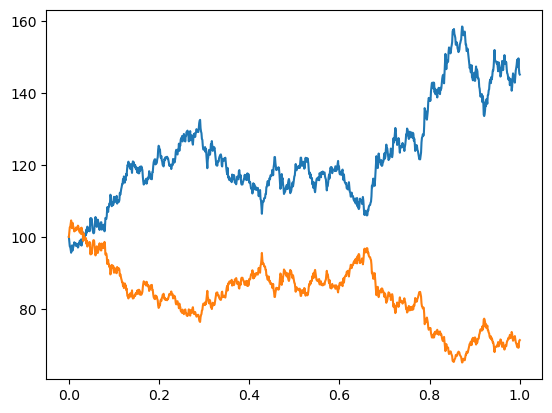

In [16]:
t, S1, S2 = gen_stock_price_antithetic(100, 0.06, 0.30, 1)
plt.plot(t, S1)
plt.plot(t, S2)

In [17]:
def eur_call_antithetic(S_0, K, r, sigma, T):
  nSim = 10000
  C = np.zeros(nSim)
  for i in range(nSim):
    _, S1, S2 = gen_stock_price_antithetic(S_0, r, sigma, T)
    C_T = (np.max([S1[-1] - K, 0]) + np.max([S2[-1] - K, 0])) / 2
    C[i] = np.exp(-r * T) * C_T
    return C
# the payoff C_T is taken as an average of the two pay offs we generated by simulating two stock prices in the opposite direction
# this average of two payoffs in opposite directions reduces the variance.

In [33]:
C_antithetic = eur_call(100, 120, 0.06, 0.30, 1)

In [34]:
C_antithetic.mean()

7.1653883581089834

In [35]:
C_antithetic.std()

16.60956808330789

(0.0, 200.0)

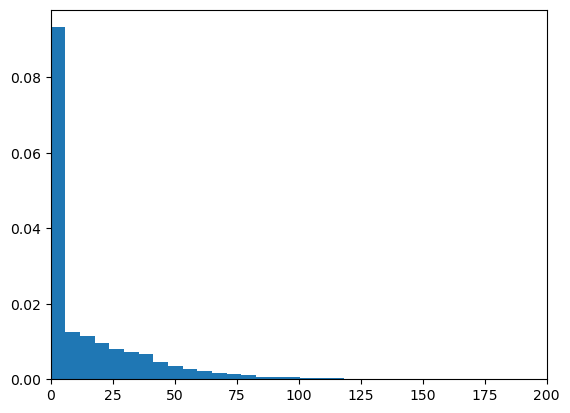

In [21]:
plt.hist(C_antithetic, bins=50, density=True)
plt.xlim((0,200))

**Asian Options**
Instead of ending stock price, we use average stock price to compute payoff, where the average is taken over one stock price per day until expiration.

In [22]:
def asian_call(S_0, K, r, sigma, T):
  nSim = 1000
  C = np.zeros(nSim)
  for i in range(nSim):
    _, S = gen_stock_price(S_0, r, sigma, T, n = int(250*T))
    C_T = np.max([S.mean() - K, 0])
    C[i] = np.exp(-r * T) * C_T
  return C.mean()

In [23]:
asian_call(100, 100, 0.06, 0.30, 1)

8.463481300686329

**Lookback Option**

In [26]:
def lookback_call(S_0, K, r, sigma, T):
  nSim = 1000
  C = np.zeros(nSim)
  for i in range(nSim):
    _, S = gen_stock_price(S_0, r, sigma, T)
    C_T = np.max([S.max() - K, 0])
    C[i] = np.exp(-r * T) * C_T
  return C.mean()

In [27]:
lookback_call(100, 100, 0.06, 0.30, 1)

27.134961784797806

**BARRIER OPTIONS**

False


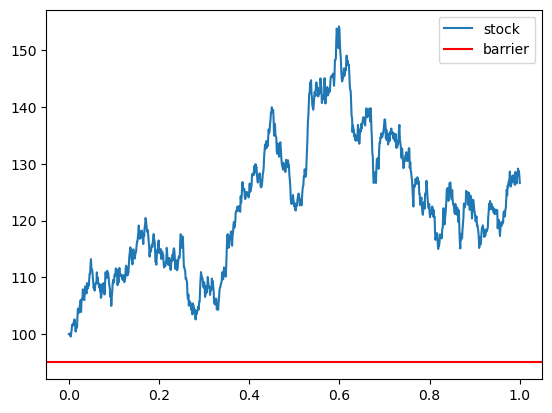

In [19]:
# check how barrier works
t, S = gen_stock_price(100, 0.06, 0.30, 1)
# Barrier = 95
print(np.any(S < 95))
plt.plot(t, S, label = 'stock')
plt.axhline(y = 95, label = 'barrier', color = 'red')
plt.legend()

In [54]:
def down_out_call(S_0, K, B, r, sigma, T):
  nSim = 1000
  C = np.zeros(nSim)
  for i in range(nSim):
    t, S = gen_stock_price(S_0, r, sigma, T)
    # check if any stock price is less than barrier
    barrier_cross = np.any(S < B)
    if not barrier_cross:
      dt = t[1] - t[0]
      barrier_cross_prob = np.exp(-2*(S[1:]-B)*(S[:-1]-B) / (sigma**2 * dt))
      U = np.random.uniform(0, 1, size = len(barrier_cross_prob))
      barrier_cross = np.any(U < barrier_cross_prob)
    if not barrier_cross:
      C_T = np.max([S[-1] - K, 0])
      C[i] = np.exp(-r * T) * C_T
  # return (t, S, C)
  return C.mean()

[0.]


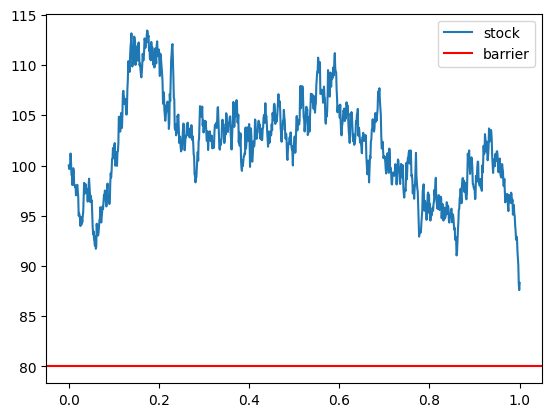

In [53]:
t, S, C = down_out_call(100, 100, 80, 0.06, 0.30, 1)
print(C)
plt.plot(t, S, label = 'stock')
plt.axhline(y = 80, label = 'barrier', color = 'red')
plt.legend()

In [55]:
down_out_call(100, 100, 95, 0.06, 0.30, 1)

6.693377571243426